In [6]:
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt

In [7]:
df = web.DataReader('AAPL', data_source='yahoo',start='2012-01-01', end='2022-02-16')
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-03,14.732143,14.607143,14.621429,14.686786,302220800.0,12.575917
2012-01-04,14.810000,14.617143,14.642857,14.765714,260022000.0,12.643497
2012-01-05,14.948214,14.738214,14.819643,14.929643,271269600.0,12.783868
2012-01-06,15.098214,14.972143,14.991786,15.085714,318292800.0,12.917508
2012-01-09,15.276786,15.048214,15.196429,15.061786,394024400.0,12.897018
...,...,...,...,...,...,...
2022-02-10,175.479996,171.550003,174.139999,172.119995,90865900.0,172.119995
2022-02-11,173.080002,168.039993,172.330002,168.639999,98566000.0,168.639999
2022-02-14,169.580002,166.559998,167.369995,168.880005,86062800.0,168.880005


In [8]:
data = df.filter(['Close'])
dataset=data.values
training_data_len = math.ceil(len(dataset)*.8)
training_data_len

2040

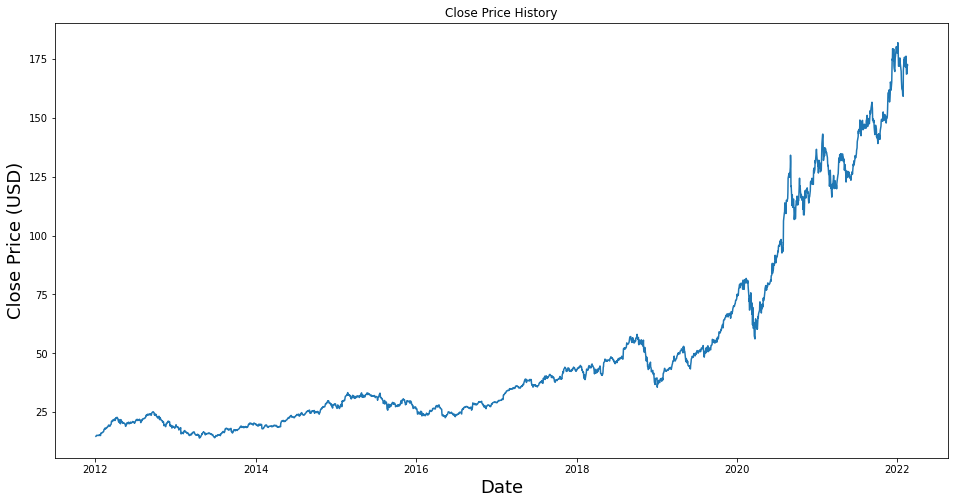

In [9]:
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price (USD)',fontsize=18)
plt.show()

In [10]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.00439887],
       [0.00486851],
       [0.00584391],
       ...,
       [0.92187436],
       [0.94513945],
       [0.94371147]])

In [11]:
train_data = scaled_data[0:training_data_len , :]
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<=60:
        print(x_train)
        print(y_train)
        print()

[array([0.00439887, 0.00486851, 0.00584391, 0.00677256, 0.00663019,
       0.00695107, 0.00680444, 0.00655793, 0.00622217, 0.00726133,
       0.00819848, 0.00790947, 0.0063263 , 0.00783722, 0.00634968,
       0.01192796, 0.01149658, 0.01205972, 0.01327737, 0.01401476,
       0.01395314, 0.01372576, 0.01469479, 0.01560643, 0.01663922,
       0.01830739, 0.02181161, 0.02186474, 0.02381555, 0.02527333,
       0.0227679 , 0.02373267, 0.02371354, 0.02641875, 0.02603411,
       0.026746  , 0.02802528, 0.02873719, 0.03078787, 0.03228178,
       0.03271317, 0.03286405, 0.03030973, 0.02969346, 0.02978484,
       0.03218616, 0.03286193, 0.03431335, 0.03773469, 0.04229932,
       0.04144504, 0.04144716, 0.04474738, 0.04578017, 0.04504489,
       0.04437338, 0.04367423, 0.04599691, 0.04759072, 0.04825798])]
[0.04660893460974819]



In [12]:
x_train,y_train = np.array(x_train), np.array(y_train)

In [13]:
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1], 1))
x_train.shape

(1980, 60, 1)

In [14]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (x_train.shape[1],1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [15]:
model.compile(optimizer='adam',loss='mean_squared_error')

In [16]:
model.fit(x_train, y_train, batch_size=1, epochs=1)

1980/1980 [==============================] - 66s 31ms/step - loss: 1.9616e-04


In [17]:
test_data = scaled_data[training_data_len-60: , :]
x_test=[]
y_test=dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

In [18]:
x_test = np.array(x_test)

In [19]:
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [20]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

In [21]:
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

0.4902688196927953

C:\Users\kapoo\AppData\Local\Temp/ipykernel_8972/2133332622.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


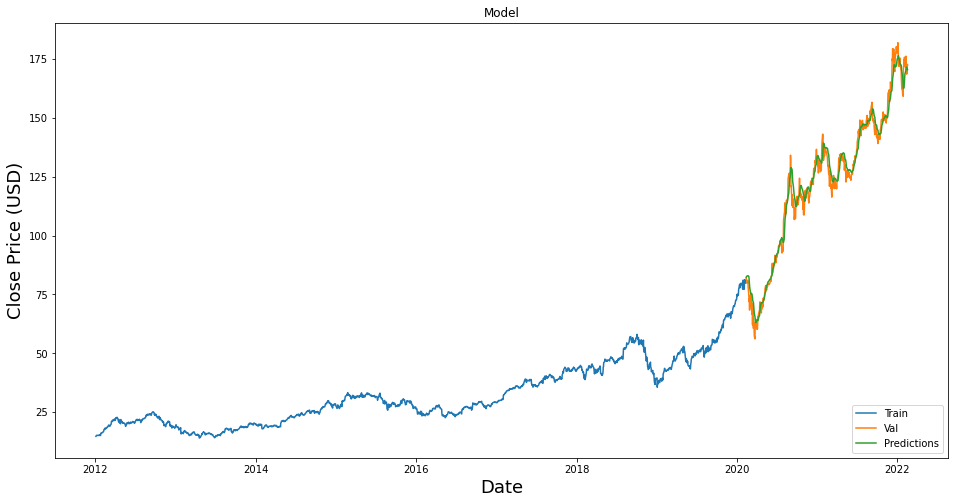

In [22]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price (USD)',fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc ='lower right')
plt.show()

In [23]:
valid

,Close,Predictions
Date,,
2020-02-12,81.800003,82.203293
2020-02-13,81.217499,82.461533
2020-02-14,81.237503,82.701637
2020-02-18,79.750000,82.912407
2020-02-19,80.904999,82.924026
...,...,...
2022-02-10,172.119995,171.394485
2022-02-11,168.639999,171.611389
2022-02-14,168.880005,171.231995


In [24]:
apple_quote = web.DataReader('AAPL', data_source='yahoo',start='2012-01-01', end='2022-02-16')
new_df = apple_quote.filter(['Close'])
last_60_days = new_df[-60:].values
last_60_days_scaled = scaler.transform(last_60_days)
X_test=[]
X_test.append(last_60_days_scaled)
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
pred_price = model.predict(X_test)
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)

[[170.47208]]


In [26]:
apple_quote2 = web.DataReader('AAPL', data_source='yahoo',start='2012-01-01', end='2022-02-16')
print(apple_quote2['Close'])

Date
2012-01-03     14.686786
2012-01-04     14.765714
2012-01-05     14.929643
2012-01-06     15.085714
2012-01-09     15.061786
                 ...    
2022-02-10    172.119995
2022-02-11    168.639999
2022-02-14    168.880005
2022-02-15    172.789993
2022-02-16    172.550003
Name: Close, Length: 2549, dtype: float64
